In [21]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, recall_score, precision_score # métrica de evaluación
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import sys
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split


In [11]:
df = pd.read_csv('../../datasets/emails.zip')
df.columns

Index(['text', 'spam'], dtype='object')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


Para ayudar a los transformadores convierto a string, no es estrictamente necesario.

In [13]:
df["text"] = df["text"].astype("string")

¿Estamos balanceados?

<Axes: xlabel='spam', ylabel='count'>

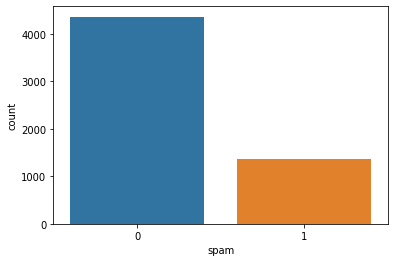

In [14]:
sns.countplot(x="spam", data=df, hue='spam', legend=False)

El transformador genera una "matriz dispersa" 

In [15]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=CountVectorizer()


In [16]:
df_vec = vectorizer.fit_transform(df['text'])


5728 registros y 37303 palabras

In [17]:
df_vec.shape

(5728, 37303)

In [18]:
X=df_vec
y=df["spam"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

clf = MultinomialNB()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1308
           1       0.96      1.00      0.98       411

    accuracy                           0.99      1719
   macro avg       0.98      0.99      0.99      1719
weighted avg       0.99      0.99      0.99      1719



Excelente rendimiento (Sensible al envenenamiento bayesiano)

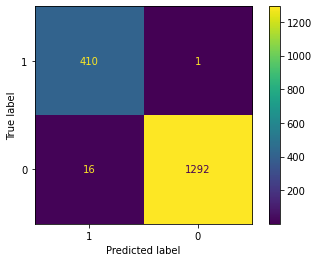

In [19]:
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(clf.classes_))
disp.plot()

In [41]:
dfp = pd.DataFrame(np.sort(clf.predict_proba(X_test)[:,1])[::-1], columns=['Propension'])
dfp.sample(10).sort_values('Propension', ascending=False)

,Propension
185,1.000000e+00
380,9.999999e-01
750,9.328849e-30
774,3.770613e-32
893,8.186059e-43
1014,1.599099e-55
1032,4.307854e-58
1261,1.375242e-93
1334,1.073639e-108
1462,2.478785e-143


Es el mejor modelo que tengo, pero todavia puedo hacer mas. Parece que 1 spam entro como correo verdadero y 16 verdaderos fueron a spam, realmente no quiero que los correos buenos vayan a spam, quiero priorizar que me llegue todo a la bandeja de entrada salvo que este muy muy seguro de que es spam. 

Modifiquemos el threshold entonces

Accuracy: 0.99, precision: 0.96, recall: 1.00, especificidad: 0.99


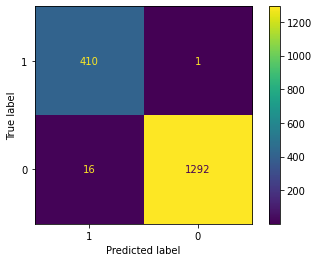

In [23]:
y_pred = (clf.predict_proba(X_test)[:,1]>0.5)
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
tp, fn, fp, tn = cm.ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(clf.classes_),)
disp.plot()
print("Accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}, especificidad: {:.2f}"
      .format(accuracy_score(y_test, y_pred), 
              precision_score(y_test, y_pred), 
              recall_score(y_test, y_pred), 
              tn/(tn+fp)
              ))

Aumento la propensión. Para indicar que es spam tiene que tener una propensión de 0.9. Gane 3 correos mas, aumenta el "error tipo 1", es decir predije "no spam" y "era spam", pero a mi, ahora me interesa tener todo en la bandeja de entrada, si me llega algun spam no es problema (Pero si es problema que correos buenos vayan a spam)  

Accuracy: 0.99, precision: 0.97, recall: 0.99, especificidad: 0.99


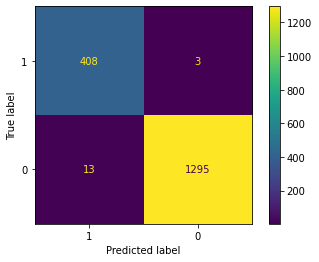

In [30]:
y_pred = (clf.predict_proba(X_test)[:,1]>0.9)
cm = confusion_matrix(y_test, y_pred)
cm = np.rot90(cm, 2)
tp, fn, fp, tn = cm.ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.flip(clf.classes_),)
disp.plot()
print("Accuracy: {:.2f}, precision: {:.2f}, recall: {:.2f}, especificidad: {:.2f}"
      .format(accuracy_score(y_test, y_pred), 
              precision_score(y_test, y_pred), 
              recall_score(y_test, y_pred), 
              tn/(tn+fp)
              ))